<a href="https://colab.research.google.com/github/hurrialice/uncertainties/blob/master/mini_regression_ZH1215.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
random.seed(42)

# AM207 final project: Uncertainty modeling

The paper we chose is [what-uncertainties-do-we-need](https://papers.nips.cc/paper/7141-what-uncertainties-do-we-need-in-bayesian-deep-learning-for-computer-vision.pdf)
> what uncertainties do we need in Bayesian Neural Network?

The notebook is structured as

- Background
- A pedigogical example: Neural Network with `cos`
- discussion for the results

## Background

There are two types of uncertainties in any machine learning task. The first is epistemic uncertainty - which is **aleatoric uncertainty** associated with observation e.g. image occulsion; and **epistemic uncertainty** associated with model that can be reduced given enough data.

Bayesian Neural Network aims to find posterior which is $P(W|D)=\frac{P(D|W)P(W)}{P(D)}$ However $P(D)$ part is very hard - we will hardly get the true distribution of data. However Monte-Carlo samples could help us approximate $P(W|D)$ by applying dropout. 

The paper proposed that we can model epistemic uncertainty along, aleatoric uncertainty along and both together, since aleatoric uncertainty can be learnd as learned loss attentuation - making loss more robust to noisy data.


## Minimal regression example

Here we devised a simple neural network with dropout that gives both predicted y and a noise term $\log\sigma^2$. We use a very simple design of neural network - four consecutive fully connected layers of `hidden_size`. We used `ReLU` as activation function and used dropout at every layer. `Dropout` is preserved as a MC sampling regime - we apply dropout at both testing and training time, therefore we could approximate a MC sampling approach. 

For this example, first we will generate training and testing data by `gen_data`. The form of any neural network can be presented as 
$$
Y = f_w(X) + \sigma(X)
$$

Therefore we designed `mean_fun` for $f_w(X)$ and `std_fun` for $\sigma(X)$. The additional params are `hetero` and `occulude` - the first refers to adding heteroskedestic erorr - $\epsilon \sim N(0, \sigma(x_i))$ rather than constant variance $\epsilon \sim N(0, \sigma)$. `occlude` signfies if we engineer a region (a quarter of values by default) to be comparatively sparse.

In this minimal regression example, we use $\sigma(X) = 0.3(x+2)$ in heteroskedastic case and a constant $N(0, 0.1)$ for hemoskedastic case. The ground truth is designed to be `cos` function for its symmetry over 0.

In [0]:
STD_FUNC = lambda x: 0.3*(x+2)
MEAN_FUNC = np.cos

def gen_data(mean_fun = MEAN_FUNC, std_fun = STD_FUNC, hetero = True, occlude = True, train_abs=2, test_abs=5):
    """
    mean_fun and std_fun: two normal function to 
    engineer relatinship y = f_w(x) + sigma(x)
    # please keep std_fun larger than zero
    
    train/test abs are the absolute value of x ranges
    
    return two sets of tensor pairs
    """
    # test data as ground truth
    test_vec_size = int(500)
    x_test = np.linspace(-test_abs, test_abs, test_vec_size)
    y_test = mean_fun(x_test)
    
    # train data with some problem
    train_vec_size = int(test_vec_size * 0.5)
    x_train = np.linspace(-train_abs, train_abs, train_vec_size)
    y_train = mean_fun(x_train)
    
    plot_title = "data:"
    if hetero:
        plot_title = plot_title + " heteroskedastic"
        noise = np.random.normal(0, np.abs(std_fun(x_train)), train_vec_size)
        y_train = y_train + noise
    else:
        y_train = y_train + np.random.normal(0, 0.3, train_vec_size)
    
    if occlude:
        plot_title = plot_title + " occlusion"
        indicies = np.arange(train_vec_size)
        n_piece = indicies//(train_vec_size/4)
        new_indicies = np.concatenate((indicies[n_piece != 1], indicies[n_piece == 1][1::5]), axis=None)
        y_train = y_train[new_indicies]
        x_train = x_train[new_indicies]
    
    # plot
    plt.figure(figsize=(12, 4))
    plt.scatter(x_test, y_test, c="orange",s=7, label = "test")
    plt.scatter(x_train, y_train, s=7, label = "train")
    plt.legend()
    plt.title(plot_title)
    
    # turn all array into tensors
    x_train = torch.from_numpy(x_train).float().view(-1, 1)
    y_train = torch.from_numpy(y_train).float().view(-1, 1)
    x_test = torch.from_numpy(x_test).float().view(-1, 1)
    y_test = torch.from_numpy(y_test).float().view(-1, 1)
    
    return(x_train, y_train, x_test, y_test)

## Network structure

The network we have has simple structure, an input layer with four fully connected layer and a final output layer. There are 32 hidden nodes in each FC layer and ReLu is applied thoughout. A dropout layer is added at the end of neural network as a means for approximate Bayesian inference by MC dropout. We will train NN by 2000 epochs using Adam optimizer with LR=1e-4 and 0.001 weight decay - which is almost sure to achieve quite good fit on training data. The hyperparameters are kept identical for all experiments to make sure results are comparable.

## Model Uncertainties: A-only, E-only and combined

For Aleatoric-only model, we assume no variance in predictives. Therefore we will disable dropout in both training and testing time. For Epistemic-only model, we will disable the network arm that gives $\log\sigma$. In this case, the loss function should be a simple MSE. In practice, we set $\log\sigma$ to be a constant that does not contribute any loss. In combined case, we will apply dropout and incorporate $\log\sigma$ into network training.

In [0]:
class Net(torch.nn.Module):
    def __init__(self, p, logvar, n_feature, n_hidden, n_output):
        super().__init__()
        self.p = p
        self.logvar = logvar
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.mid1 = torch.nn.Linear(n_hidden, n_hidden)   # hidden layer
        self.mid2 = torch.nn.Linear(n_hidden, n_hidden)   # hidden layer
        self.mid3 = torch.nn.Linear(n_hidden, n_hidden)   # hidden layer
        self.mid4 = torch.nn.Linear(n_hidden, n_hidden)   # hidden layer

        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
        self.get_var = torch.nn.Linear(n_hidden, n_output)
        
    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = F.relu(self.mid1(x))      # activation function for hidden layer
        x = F.relu(self.mid2(x))
        x = F.relu(self.mid3(x))
        x = F.relu(self.mid4(x))
        
        x = F.dropout(x, p = self.p)
        
        # get y and log_sigma
        y = self.predict(x)
        if self.logvar:
            logvar = self.get_var(x)
        else:
            logvar = torch.zeros(y.size()) 
        return y, logvar

class aleatoric_loss(nn.Module):
    def __init__(self):
        super(aleatoric_loss, self).__init__()
    def forward(self, gt, pred_y, logvar):
        loss = torch.sum(0.5*(torch.exp((-1)*logvar)) * (gt - pred_y)**2 + 0.5*logvar)
        return loss

def train_model(network, loss_function, X, y, 
                number_epochs=1000, learning_rate = 1e-4, weight_decay=0.001):
    """
    network: an instance of the Net Class
    loss function: an instance of loss Class
    opt: an instance of optimizer class
    """
    optimizer = optim.Adam(network.parameters(), 
                           lr=learning_rate, 
                           weight_decay=weight_decay)
    for t in range(number_epochs):
        prediction, log_var = network(X)

        loss = loss_function(y, prediction, log_var)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

    return network

def get_MC_samples(network, X, dropout = True, mc_times=64):
    pred_v = []; a_u = []

    for t in range(mc_times):
        if dropout:
            prediction, var = network(X)
        else:
            network.eval()
            prediction, var = network(X)

        pred_v.append(prediction.data.numpy())
        a_u.append(var.data.numpy())

    pred_v = np.array(pred_v); a_u = np.array(a_u)
    a_u = np.sqrt(np.exp(np.mean(a_u, axis=0)))
    pred_mean = np.mean(pred_v, axis=0)
    e_u = np.sqrt(np.var(pred_v, axis=0))
    return pred_mean.squeeze(), a_u.squeeze(), e_u.squeeze()

def view_uncertainty(fig_title, pred_val, ale_val, epi_val, x_train, y_train, x_test, y_test):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12,4))
    for ax in axs:
        ax.scatter(x_test, y_test, c="orange",s=7, label = "test")
        ax.scatter(x_train, y_train, s=7, label = "train")
        ax.plot(x_test, pred_val,c="red", label = "predict")
    
    if np.mean(ale_val) != 1: # a tricky hack here
        axs[0].fill_between(x_test.squeeze(), pred_val-ale_val, pred_val+ale_val, 
                         label = "Aleatoric", alpha=0.5)
    else:
        axs[0].fill_between(x_test.squeeze(), pred_val, pred_val, 
                         label = "Aleatoric", alpha=0.5)
    if np.sum(epi_val) != 0:
        axs[1].fill_between(x_test.squeeze(), pred_val-epi_val, pred_val+epi_val,
                         label = "Epistemic", alpha = 0.5)
    axs[0].legend(); axs[1].legend()
    fig.suptitle(fig_title)
    plt.show()
    
def viz_uncertainty(if_drop, if_ale, fig_title, default_p=0.5):
    if not if_drop:
        p = 0
    else: 
        p = default_p
    net = Net(p, if_ale, *NET_STRUCTURE)
    net = train_model(net, LOSS, *DATASET[0:2], **TRAIN_PARAMS)
    args = get_MC_samples(net, DATASET[2], dropout = if_drop)
    view_uncertainty(fig_title, *args, *DATASET)
    return(net)

def vis_three_models(p=0.5):
    _ = viz_uncertainty(False, True, "Aleatoric Only", default_p=p)
    _ = viz_uncertainty(True, False, "Epistemic Only", default_p=p)
    _ = viz_uncertainty(True, True, "Combined", default_p=p)
    pass

In [0]:
NET_STRUCTURE = [1, 32, 1]
TRAIN_PARAMS=dict(number_epochs=2000, learning_rate = 1e-4, weight_decay=0.001)
LOSS = aleatoric_loss() 

### Case 1: Homoskedastic

The first dataset assumes homoskedestic noise and no occlusion. Aleatoric uncertainty, which measures the intrinsic noise with data, is homogenenous along X axis, for both "Aleatoric only" and "combined" models. Epistemic uncertainty, which is a measure of uncertainty from void of data, gets larger as the model tries to predict for inputs that are not seen in training data ($[-5, -2],[2, 5]$)

**The question is why we have large value for both uncertainty near 0 - this is quite counter-intuitive! Is it because it is near a minima & due to some feature of Adam optimzer..?**

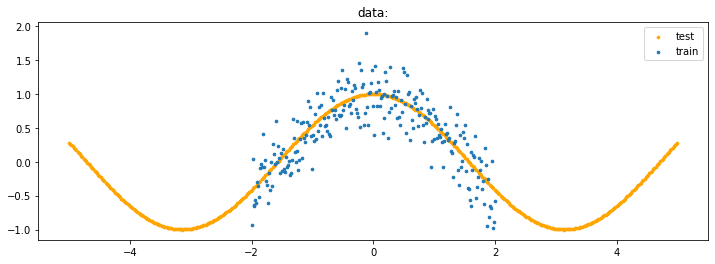

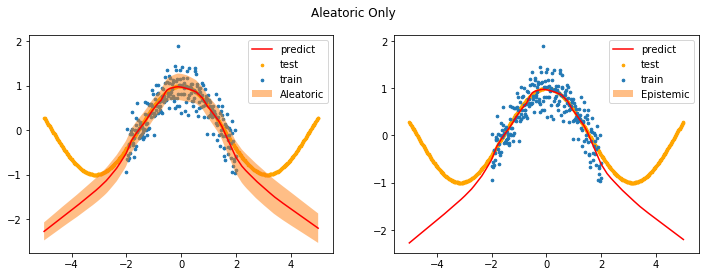

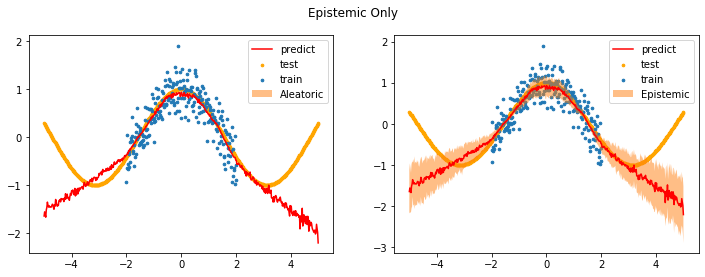

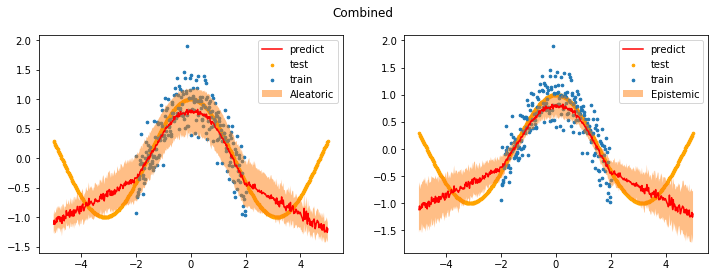

In [5]:
DATASET = gen_data(occlude=False, hetero=False)
vis_three_models()

### Case 2: Homoskedastic with Occlusion

With engineered occlusion at $[-1,0]$ we can observe more epistemic uncertainty there in "Epistemic-only" model. Aleatoric uncertainty in combined model is relative constant within the range of training data, but becomes zero as the model predicts inputs it has never seen. 

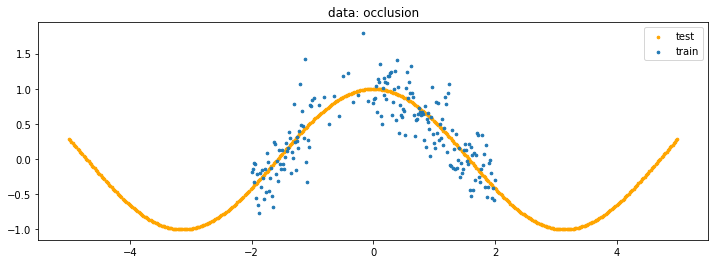

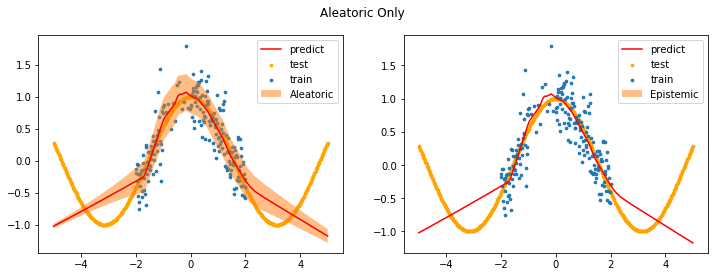

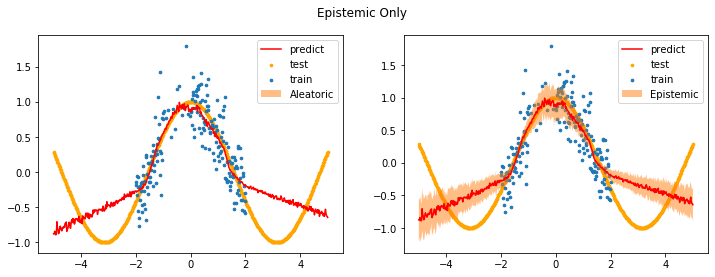

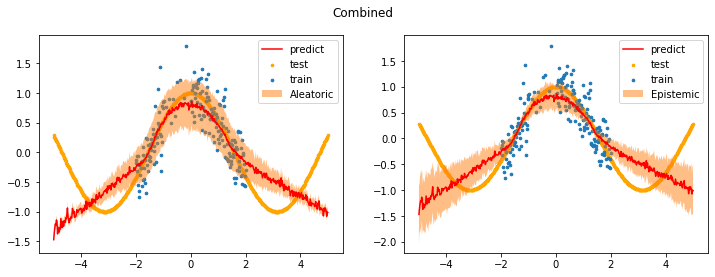

In [6]:
DATASET = gen_data(occlude=True, hetero=False)
vis_three_models()

### Case 3: Heteroskedastic data
Aleatoric uncertainty increases as the variance of training data increase with X, while epistemic uncertainty remains stable in $[-2,2]$.

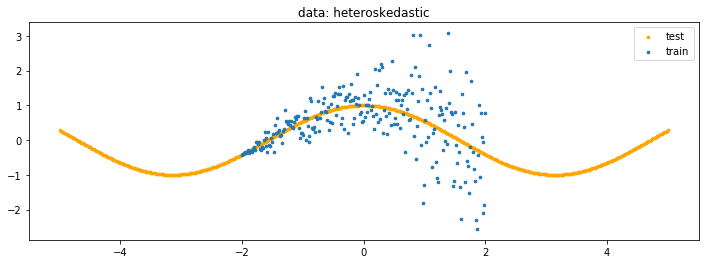

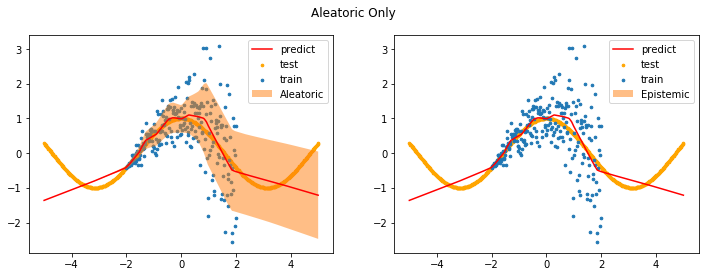

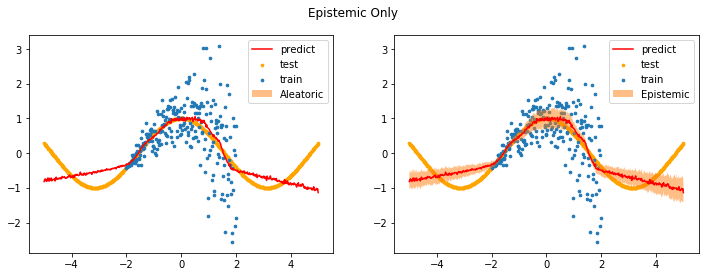

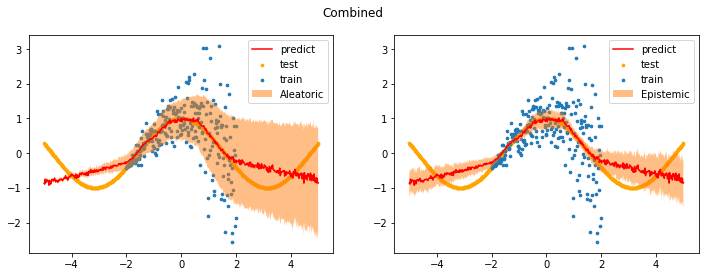

In [7]:
DATASET = gen_data(occlude=False, hetero=True)
vis_three_models()

### Case 4: Heteroskedastic with Occlusion

Aleatoric uncertainty captures and noise function while epistemic uncertainty capture uncertainty in inputs, which means it will gets larger when traning data is sparse there.

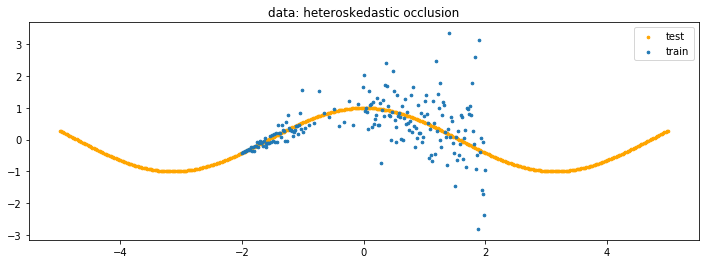

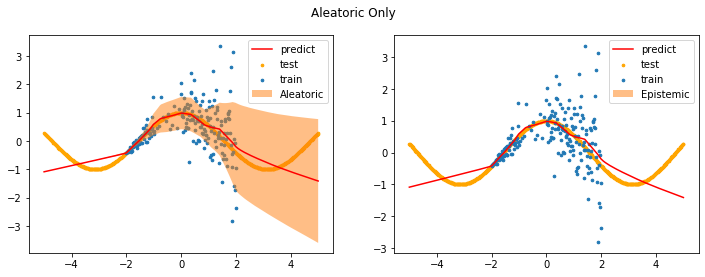

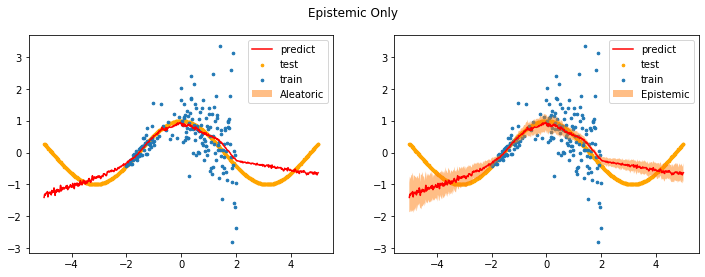

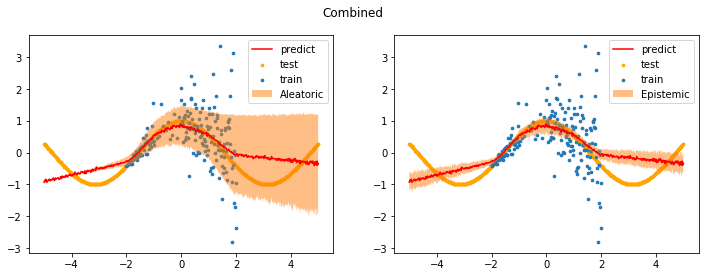

In [8]:
DATASET = gen_data(occlude=True, hetero=True)
vis_three_models()

### Case 4: Heteroskedastic with sin noise

We want to test the behavior of this model when dealing with more complex noise. Here we change the amplitude of noise of train data to be a sin form. When only aleatoric uncertainty is included in the model, the model can qualitatively capture the sin-form noise. However, when both aleatoric and epestemic uncertainties are included, the aleatoric uncertainty is much smoother. 


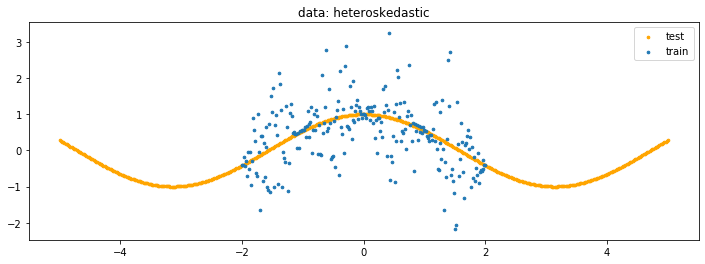

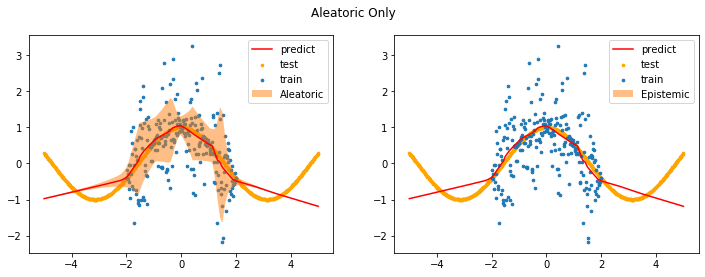

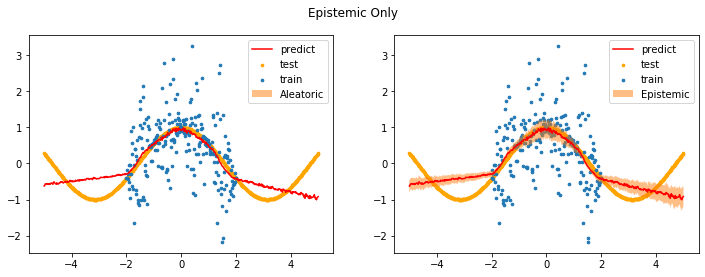

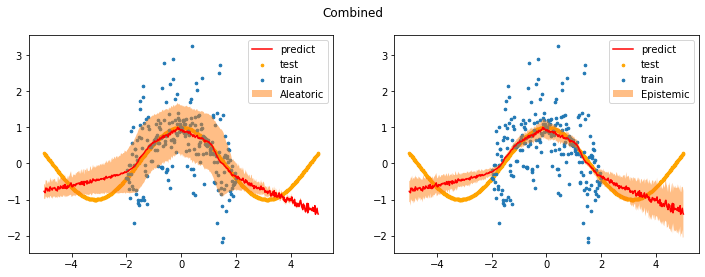

In [9]:
STD_SIN = lambda x: np.sin(2*np.pi*x/2)
DATASET = gen_data(std_fun = STD_SIN, occlude=False, hetero=True)
vis_three_models()

Here we change the frequency of sin function. The aleatoric uncertainty is still smoother in the model combining both uncertainties than in the model only including aleatoric uncertainty. These results suggest that, when this paper tries to combine the two type of uncertainty in one model, the predicted aleatoric uncertainty becomes less reliable. Interestingly, for the test region not containing any train data (below -2 and above 2), the aleatoric uncertainty is totally different for two different sin function. This also suggest the predicted aleatoric uncertainty is not reliable where the test region is not covered by train data.

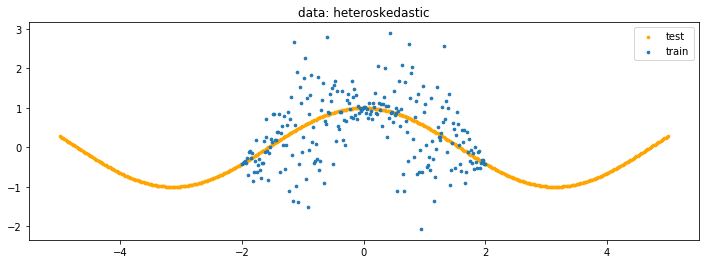

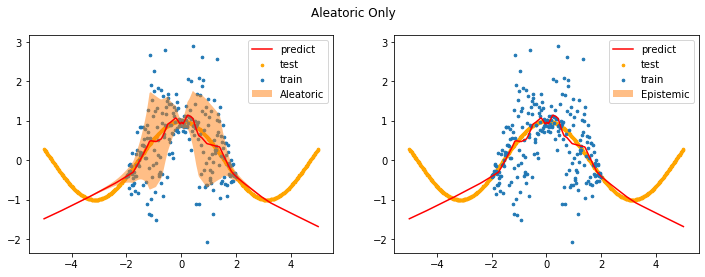

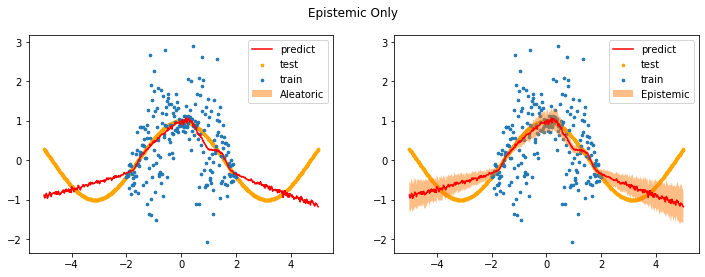

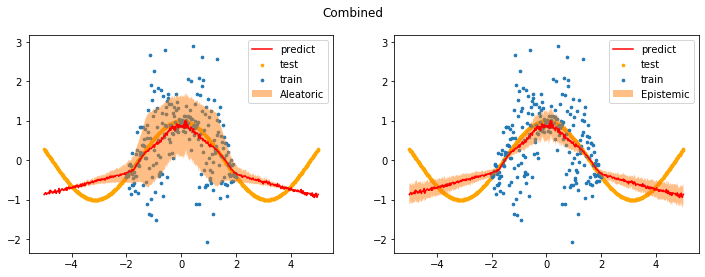

In [10]:
STD_SIN = lambda x: np.sin(2*np.pi*x/4)
DATASET = gen_data(std_fun = STD_SIN, occlude=False, hetero=True)
vis_three_models()

### Case 5: Testing the influence of dropout probability p

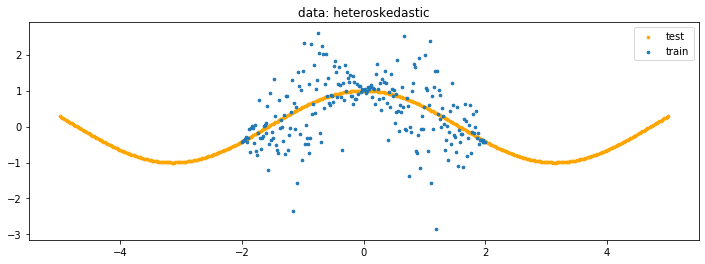

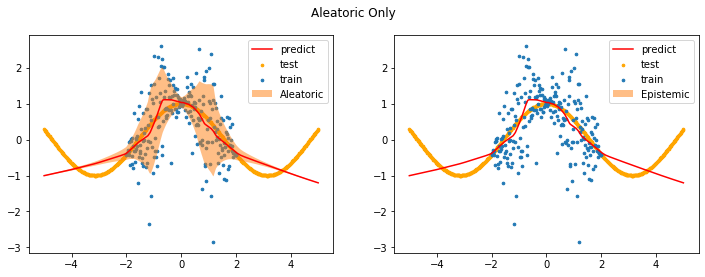

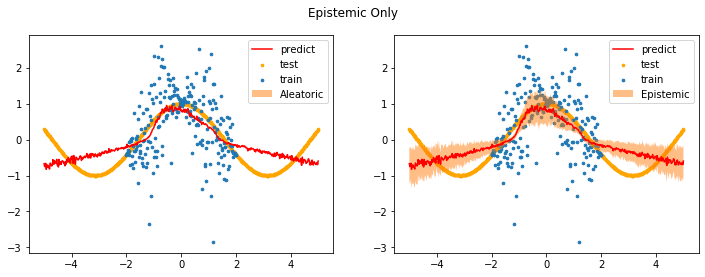

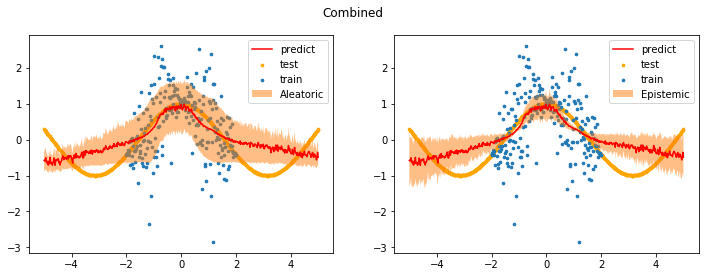

In [11]:
STD_SIN = lambda x: np.sin(2*np.pi*x/4)
DATASET = gen_data(std_fun = STD_SIN, occlude=False, hetero=True)
vis_three_models(p=0.8)

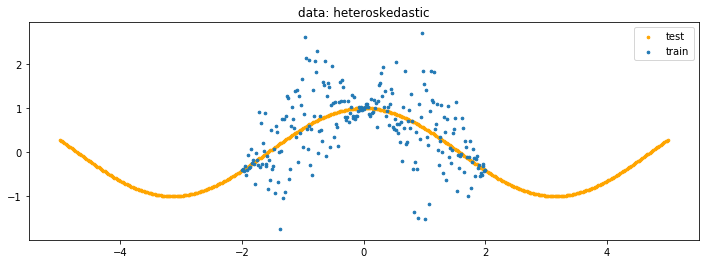

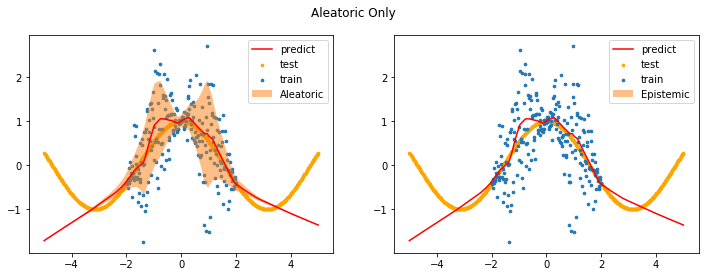

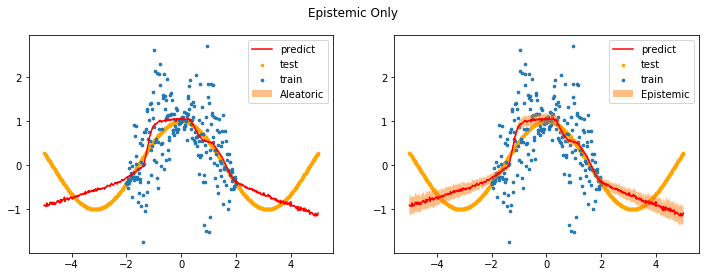

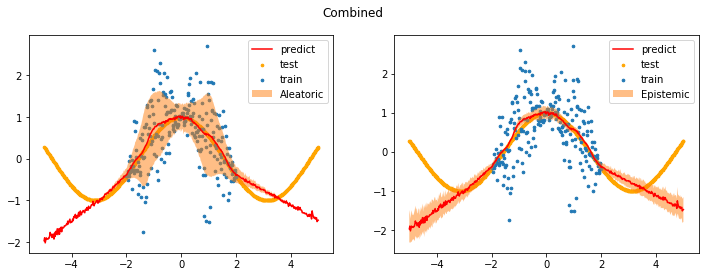

In [12]:
STD_SIN = lambda x: np.sin(2*np.pi*x/4)
DATASET = gen_data(std_fun = STD_SIN, occlude=False, hetero=True)
vis_three_models(p=0.2)

From the above three examples (including the last example in Case 4) with p = 0.5, 0.8, 0.2 respectively, we can see that, while keeping everything else the same, increasing p leads to larger epistemic uncertainty in the region where training data covers. Interestingly, when p = 0.2, the aleatoric uncertainty in the model combining the two uncertainty well captures the sin-form noise. This suggest as p increases, the aleatoric will get smoother due to the effect of dropout. This intuitively makes sense because when p is very close to zero, there is almost no dropout, epistemic uncertainty should be very small, and aleatoric uncertainty should be very similar to that in the model only considering aleatoric uncertainty. 

### Case 6: Testing the form of the mean function of test data

In this case we change the form of mean function from cos to a modified sigmoid function. Everything is the same as in Case 1 except the form of mean function. The results are roughly consistent with Case 1. Aleatoric uncertainty is kind of uniform, while the epistemic uncertainty increases at regions without training data coverage.

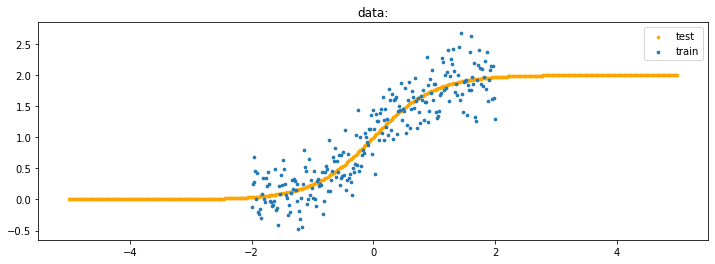

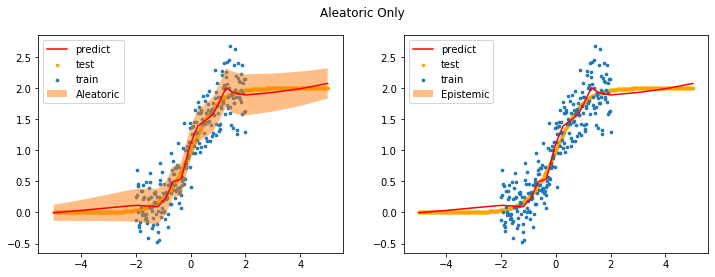

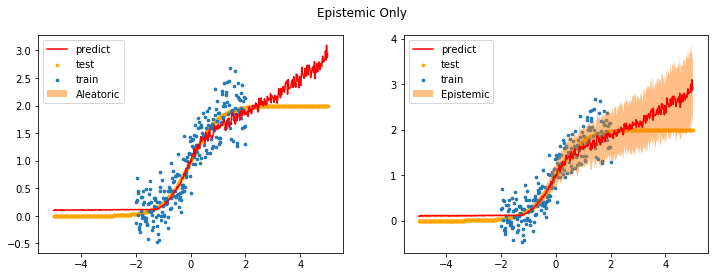

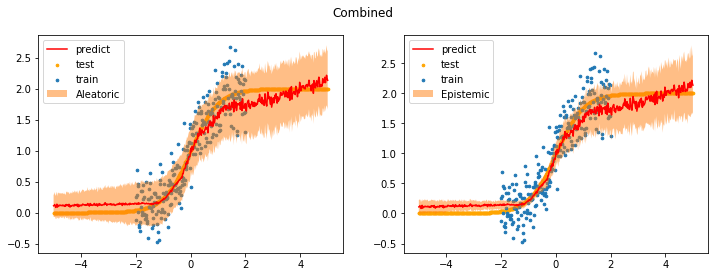

In [13]:
sigmoid = lambda z: 2. / (1. + np.exp(-2*z))
DATASET = gen_data(mean_fun = sigmoid, occlude=False, hetero=False)
vis_three_models()

### Case 7: A failure example

This case is the same as Case 1 except that here dropout rate p=0.99 and p=1. For p=1, the model with epistemic uncertainty only cannot produce epistemic uncertainty, and the full model produce a uniform, unrealistic aleatoric uncertainty, which is not correct. For p=0.99, aleatoric uncertainty behaves similar to p=1. In both case, the prediction in full model behaves really bad. This is because, when p=1 (or close to 1), the model will dropout all the nodes (or most of the nodes). Dropout all the nodes means every weight will be 0, therefore the prediction is 0 when p=1. 

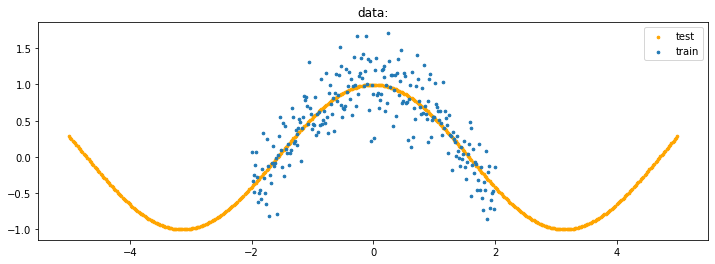

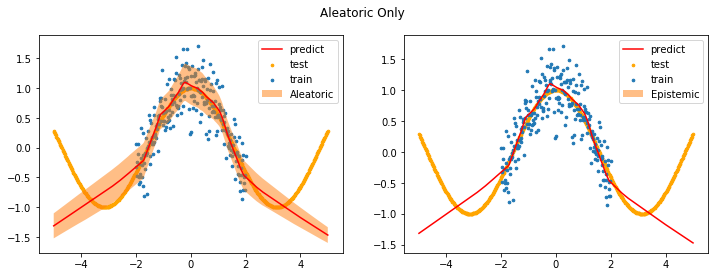

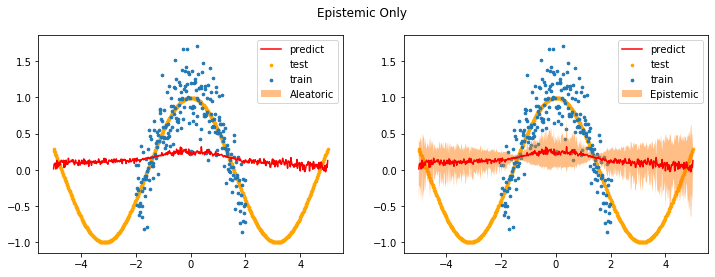

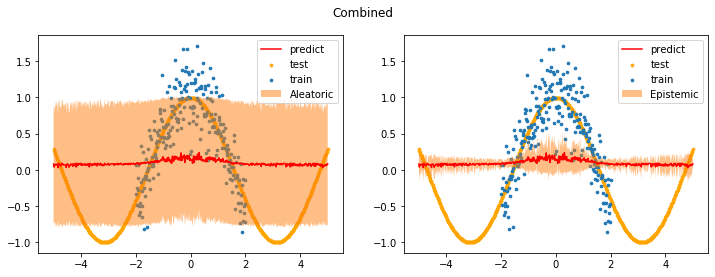

In [14]:
DATASET = gen_data(occlude=False, hetero=False)
vis_three_models(p=0.99)

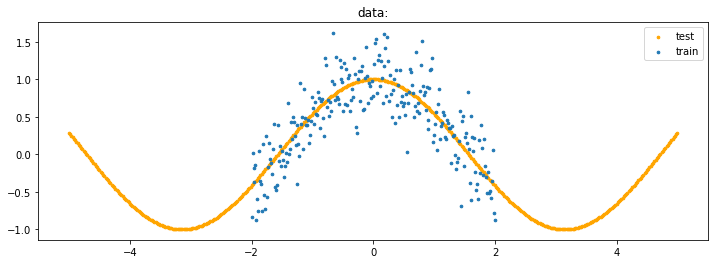

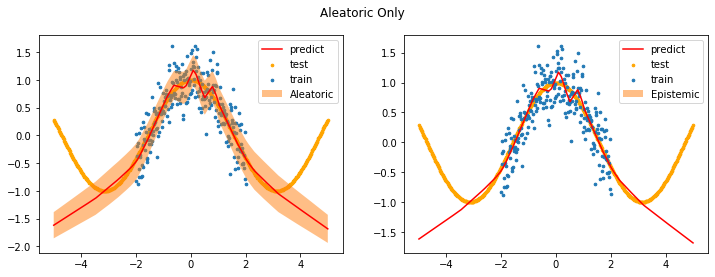

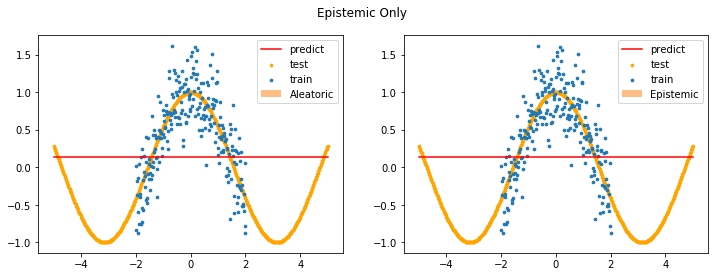

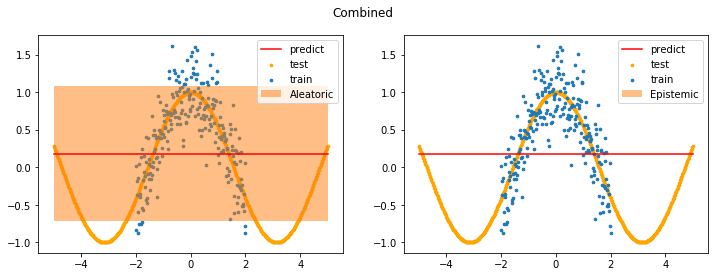

In [15]:
DATASET = gen_data(occlude=False, hetero=False)
vis_three_models(p=1)